In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
df = pd.read_csv("../data/processed/final_mine_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["zone_id", "timestamp"])

In [53]:
FEATURE_COLS = [
    "vibration_energy",
    "vibration_entropy",
    "acoustic_energy",
    "acoustic_hit_rate",
    "stress_index",
    "excavation_depth"
]

TARGET_COL = "risk_label"

X = df[FEATURE_COLS].values
y = df[TARGET_COL].values

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

WINDOW_SIZE = 10
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW_SIZE)

X_seq.shape, y_seq.shape

((890, 10, 6), (890,))

In [56]:
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

for train_idx, val_idx in sss.split(X_seq, y_seq):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

In [57]:
print("Train distribution:", np.bincount(y_train))
print("Validation distribution:", np.bincount(y_val))

Train distribution: [232 480]
Validation distribution: [ 58 120]


In [58]:
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, weights))
class_weight_dict

{0: 1.5344827586206897, 1: 0.7416666666666667}

In [59]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 64)            18176     
                                                                 
 dropout_8 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
23/23 [==============================] - 1s 13ms/step - loss: 0.4400 - accuracy: 0.7907 - val_loss: 0.2824 - val_accuracy: 0.9607
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1526 - accuracy: 0.9831 - val_loss: 0.0777 - val_accuracy: 0.9944
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9888 - val_loss: 0.0333 - val_accuracy: 0.9944
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.9888 - val_loss: 0.0281 - val_accuracy: 0.9944
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0409 - accuracy: 0.9888 - val_loss: 0.0248 - val_accuracy: 0.9944
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0353 - accuracy: 0.9888 - val_loss: 0.0220 - val_accuracy: 0.9944
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0316 - accuracy: 0.9902 - val_loss: 0.0185 - val_accuracy: 0.9944
Epoch 8/50
23/23 [=

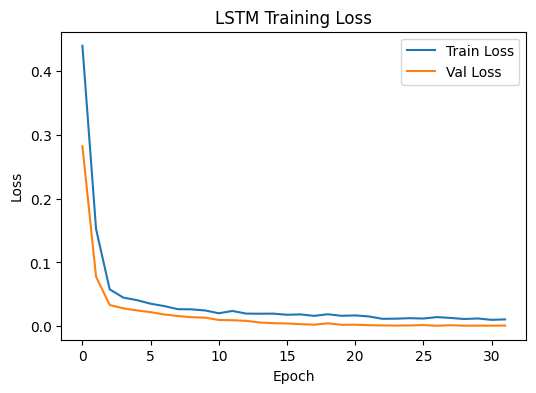

In [61]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

In [62]:
y_prob = model.predict(X_val)
y_pred = (y_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

6/6 [==============================] - 0s 1ms/step
Confusion Matrix:
[[ 58   0]
 [  0 120]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00       120

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [63]:
model.save("../models/lstm_risk_model")
print("✅ LSTM model saved successfully")

INFO:tensorflow:Assets written to: ../models/lstm_risk_model/assets


INFO:tensorflow:Assets written to: ../models/lstm_risk_model/assets


✅ LSTM model saved successfully


In [64]:
y_prob = model.predict(X_val)
y_pred = (y_prob > 0.5).astype(int)

comparison_df = pd.DataFrame({
    "Actual": y_val[:20],
    "Predicted": y_pred[:20].flatten(),
    "Probability": y_prob[:20].flatten()
})

comparison_df

6/6 [==============================] - 0s 2ms/step


,Actual,Predicted,Probability
0,1,1,0.986907
1,1,1,0.999770
2,0,0,0.001556
3,0,0,0.001885
4,1,1,0.999780
5,0,0,0.001776
6,0,0,0.001406
7,1,1,0.999769
8,1,1,0.999778
9,1,1,0.999781


In [65]:
print("Predicted class distribution:", np.bincount(y_pred.flatten()))
print("Actual class distribution:", np.bincount(y_val))

Predicted class distribution: [ 58 120]
Actual class distribution: [ 58 120]
